In [1]:
import numpy as np
import qiskit

In [2]:
from qiskit.providers.aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Statevector

In [3]:
from qiskit.test.mock import FakeVigo

# Build assertions

# A0

In [4]:
assert0_base = qiskit.QuantumCircuit(5,5, name="assert0")
assert0_base.measure(range(4),range(4))
assert0_base.barrier(range(5))

In [5]:
assert0_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5]; // Quantum Register
creg c[5]; // Classical Register
 
if (c==0) x q[4]; // q[4] == 1 means assertion passed
""")

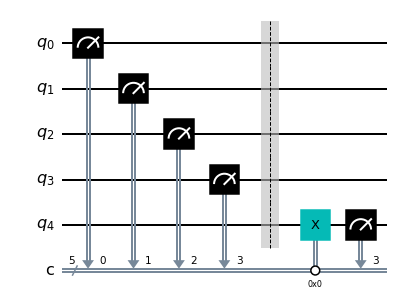

In [6]:
assert0 = assert0_base.compose(assert0_cond, range(5), front = False)
assert0.measure(4,3)
assert0.draw('mpl')

In [7]:
assert0_instr = assert0.to_instruction()

## A1

In [8]:
assert_1_base = qiskit.QuantumCircuit(4,4, name = "assert1")
assert_1_base.h(range(3))
assert_1_base.measure(range(3),range(3))
assert_1_base.barrier(range(3))
assert_1_base.h(range(3))
assert_1_base.barrier(range(4))

In [9]:
assert1_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4]; // Quantum Register
creg c[4]; // Classical Register
 
if (c==0) x q[3]; // q[3] == 1 means assertion passed
""")

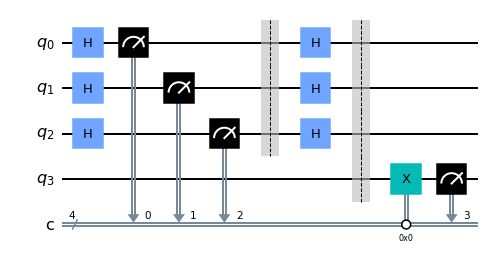

In [10]:
assert1 = assert_1_base.compose(assert1_cond, range(4), front = False)
assert1.measure(3,3)
assert1.draw('mpl')

In [11]:
assert1_instr = assert1.to_instruction()

## A2

In [12]:
assert2_base = qiskit.QuantumCircuit(3,3, name = "assert2")
assert2_base.cx(0,1)
assert2_base.h(0)
assert2_base.barrier(range(2))
assert2_base.measure(range(2),range(2))
assert2_base.barrier(range(2))
assert2_base.h(0)
assert2_base.cx(0,1)
assert2_base.barrier(range(3))

In [13]:
assert2_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3]; // Quantum Register
creg c[3]; // Classical Register
 
if (c==0) x q[2]; // q[2] == 1 means assertion passed
""")

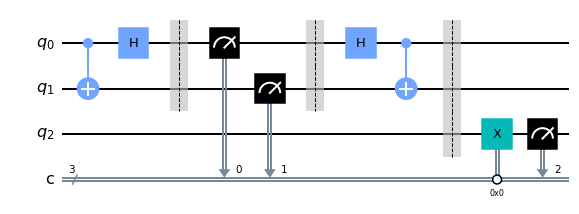

In [14]:
assert2 = assert2_base.compose(assert2_cond, range(3), front = False)
assert2.measure(2,2)
assert2.draw('mpl')

In [15]:
assert2_instr = assert2.to_instruction()

## A3

In [16]:
assert3_base = qiskit.QuantumCircuit(3,3, name = "assert3")
assert3_base.measure(range(2),range(2))
assert3_base.barrier(range(3))

In [17]:
assert3_cond = qiskit.QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";

qreg q[3]; // Quantum Register
creg c[3]; // Classical Register
 
if (c==0) x q[2]; // q[2] == 1 means assertion passed
""")

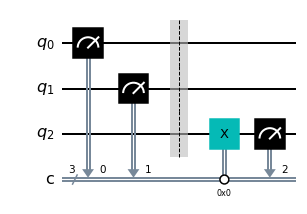

In [18]:
assert3 = assert3_base.compose(assert3_cond, range(3), front = False)
assert3.measure(2,2)
assert3.draw('mpl')

In [19]:
assert3_instr = assert3.to_instruction()

# Helper: the QFT

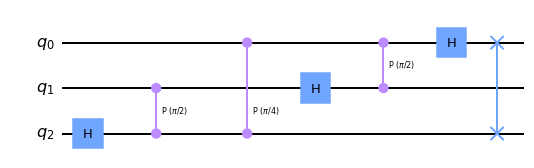

In [20]:
qft = qiskit.QuantumCircuit(3, name = "qft")
qft.h(2)
qft.cp(np.pi/2,1,2)
qft.cp(np.pi/4,0,2)
qft.h(1)
qft.cp(np.pi/2,0,1)
qft.h(0)
qft.swap(0,2)
qft.draw('mpl')

In [21]:
qft_instr = qft.to_instruction()

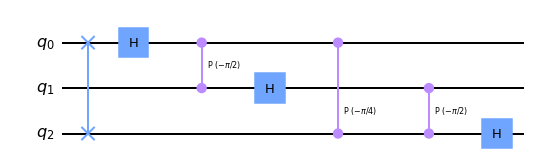

In [22]:
qft_inverse = qiskit.QuantumCircuit(3, name="qft^-1")
qft_inverse.swap(0,2)
qft_inverse.h(0)
qft_inverse.cp(-np.pi/2, 0, 1)
qft_inverse.h(1)
qft_inverse.cp(-np.pi/4, 0, 2)
qft_inverse.cp(-np.pi/2, 1, 2)
qft_inverse.h(2)
qft_inverse.draw('mpl')


In [23]:
qft_inverse_instr = qft_inverse.to_instruction()

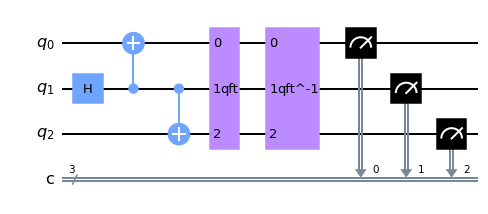

In [24]:
qft_test = qiskit.QuantumCircuit(3,3, name = "test identity")
qft_test.h(1)
qft_test.cx(1,0)
qft_test.cx(1,2)
qft_test.append(qft_instr, [0,1,2])
qft_test.append(qft_inverse_instr, [0,1,2])
qft_test.measure(range(3),range(3))

qft_test.draw('mpl')

# Shor's algorithm

/home/dsmishler/anaconda3/lib/python3.8/site-packages/qiskit/visualization/matplotlib.py:317: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  self._get_layer_widths()


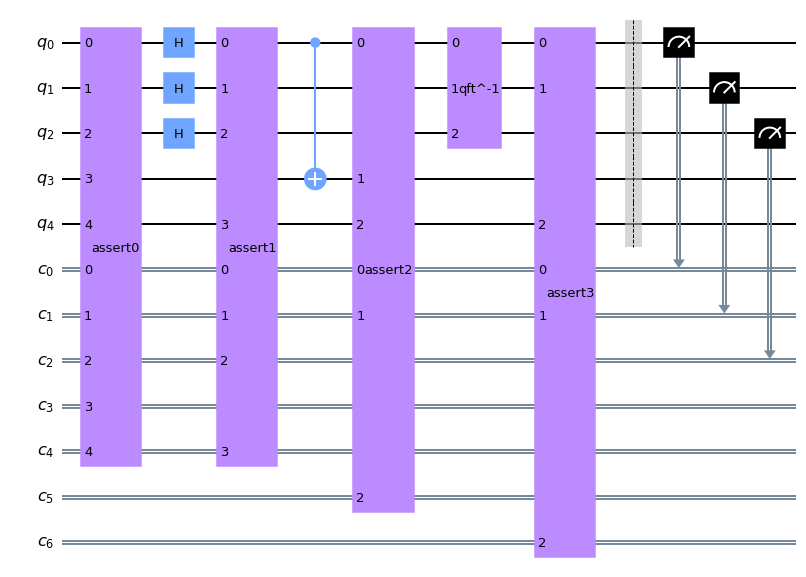

In [25]:
shors_full = qiskit.QuantumCircuit(5, 7, name = 'shors')
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full.append(assert0_instr, [0,1,2,3,4], [0,1,2,3,4])
# shors_full.rx(0.2*np.pi, range(5)) # Noise
shors_full.h(0)
shors_full.h(1)
shors_full.h(2)

shors_full.append(assert1_instr, [0,1,2,4], [0,1,2,4])

shors_full.cx(0,3)

shors_full.append(assert2_instr, [0,3,4], [0,1,5])

shors_full.append(qft_inverse_instr, [0,1,2])

shors_full.append(assert3_instr, [0,1,4], [0,1,6])

shors_full.barrier(range(5))
shors_full.measure(range(3), range(3))
shors_full.draw('mpl')

In [26]:
backend = QasmSimulator()
circ_compiled = qiskit.transpile(shors_full, backend)
job_sim = backend.run(circ_compiled, shots = 1024)
results_sim = job_sim.result()

In [27]:
counts = results_sim.get_counts(circ_compiled)
print(counts)

{'1111000': 531, '1111100': 493}


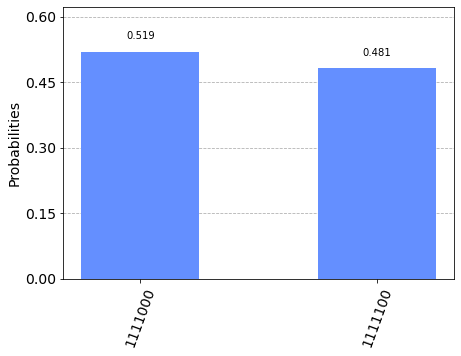

In [28]:
qiskit.visualization.plot_histogram(counts)

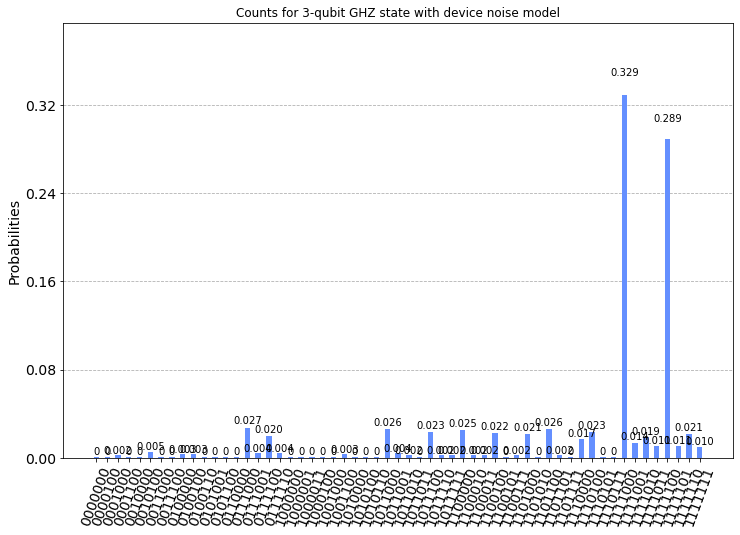

In [34]:
device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)
# Transpile the circuit for the noisy basis gates
tcirc = qiskit.transpile(shors_full, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
qiskit.visualization.plot_histogram(counts_noise,
                                   #number_to_keep=5,
                                   figsize = [12,8],
                                   #sort = 'desc',
                                   title="Counts for 3-qubit GHZ state with device noise model")

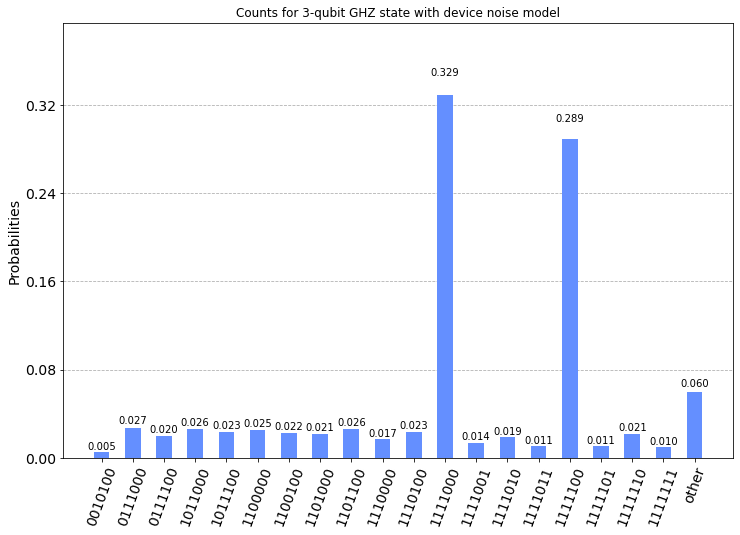

In [35]:
to_pop = []
pop_threshold = 5
for entry in counts_noise:
    if(counts_noise[entry] < pop_threshold):
        # print("filtering out", entry)
        to_pop.append(entry)
counts_noise["other"] = 0
for item in to_pop:
    counts_noise["other"] += counts_noise[item]
    counts_noise.pop(item)
qiskit.visualization.plot_histogram(counts_noise,
                               #number_to_keep=5,
                               figsize = [12,8],
                               #sort = 'desc',
                               title="Counts for 3-qubit GHZ state with device noise model")